<a href="https://colab.research.google.com/github/AnupJoseph/Knowledge-Graph/blob/master/KnowlegeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://archive.org/download/stackexchange/askubuntu.com.7z

In [0]:
!cp -r /content/drive/My\ Drive/stackoverflow/csvs /content/

In [0]:
!pip install textpipeliner

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline
nlp = spacy.load('en_core_web_sm')

In [100]:
posts = pd.read_csv("csvs/posts.csv")
posts_content = posts.body[:4000]
posts_content.head()

0    <p>Every time I turn on my computer, I see a message saying something like:</p><pre><code>Your batte
1    <p>Maybe <a href=http://linux.aldeby.org/get-rid-of-your-battery-may-be-broken-notification.html>the
2    <p>How can I set the Software Center to allow non-root users to install stuff from the Ubuntu repos 
3    <p>What are some alternatives to upgrading without using the standard upgrade system? Suppose for ex
4    <p>I have a ubuntu development server at work. It is an old rack server that is located somewhere in
Name: body, dtype: object

In [0]:
import re
def html_cleaner(post):
    if type(post) == 'string':
      post = BeautifulSoup(post)
      for s in post(['script', 'style']):
        s.decompose()
      return ' '.join(post.stripped_strings)
    else:
      return post

In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [0]:
entity_pairs = []

for post in tqdm(posts_content):
  post = html_cleaner(post)
  entity_pairs.append(get_entities(post))

entity_pairs[30:40]

In [0]:
relations = [get_relation(i) for i in tqdm(posts_content)]

In [106]:
from collections import Counter
Counter(relations).keys()

dict_keys(['batte', 'the', 'set', 'Suppose for', 'is', 'let', 'installed', 'updates from', 'Freenx', 'know of', 'allows', 'accomplish', 'followed', 'instructions</a', 'allo', 'helped', 'installing', 'nofollow', 'install', 'is by', 'Go to', 'remove', 'Is', '|', 'Mana', 'Now', 'Clic', 'wondering', 'have', 'Use', 'see', 'applets', "'s possible", 'enable many', 'googled', 's', 'think', 'take', 'hit', 'was', 'Fro', 'The', 'reconfigur', 'log out', 'added', 'make', 'Add', 'Search for', 'experienced', 'xor', 'depends', 'want', 'use', 'using', 'Go into', 'One of', 'tested before', 'are', 'Yo', 'Standard</a', 'like', 'syntax for', 'explain', 'http://www.dropbox', 'has', 'XDM', 'questions/7', 'playing with', 'wrote', 'waiting for', 'coming out', 'I', 'and', 'tha', 'running from', 'reported', 'need', 'installati', 'Unfortunat', '>', 'would', 'download', 'fwbuilder</code></pre', 'wha', 'worked', 'http://gufw.tuxfamily.org/>gu', 'open', 'g', 'click', 'noauto</code></p', 'override', 'going to', 'are 

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

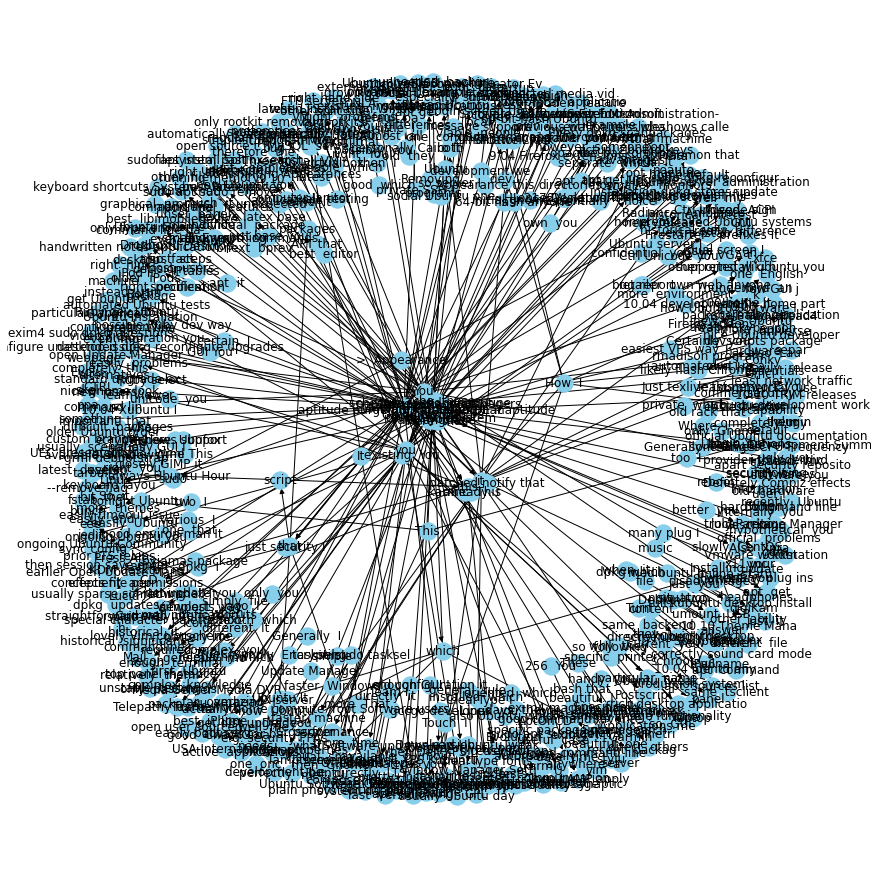

In [81]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

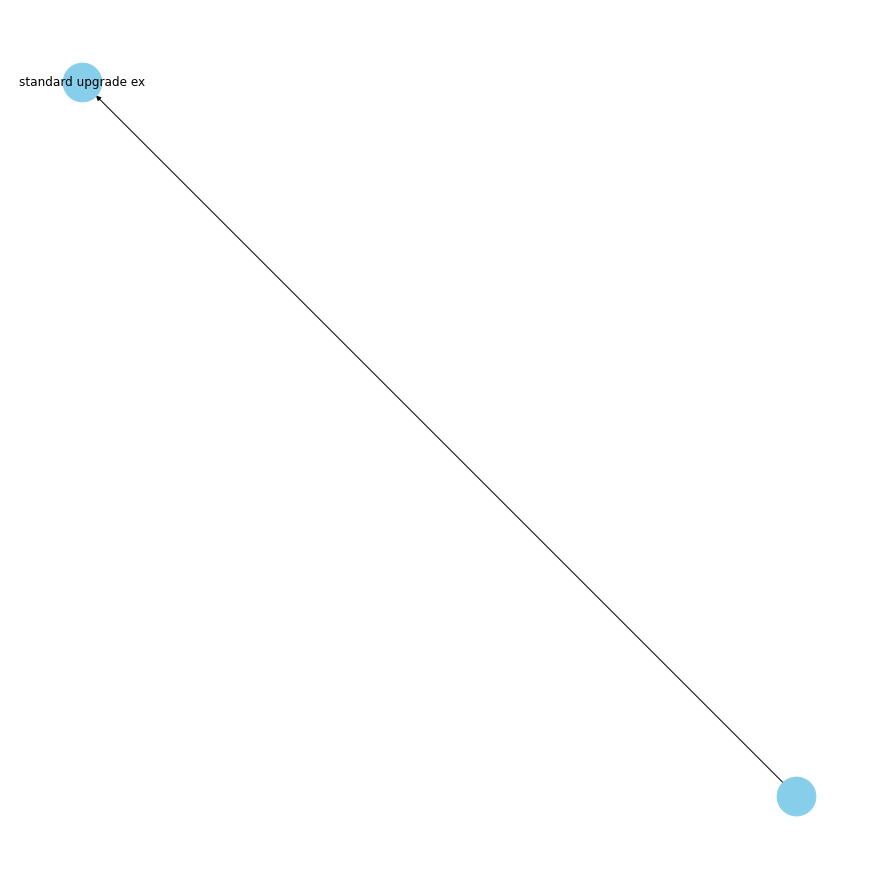

In [108]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Suppose for"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

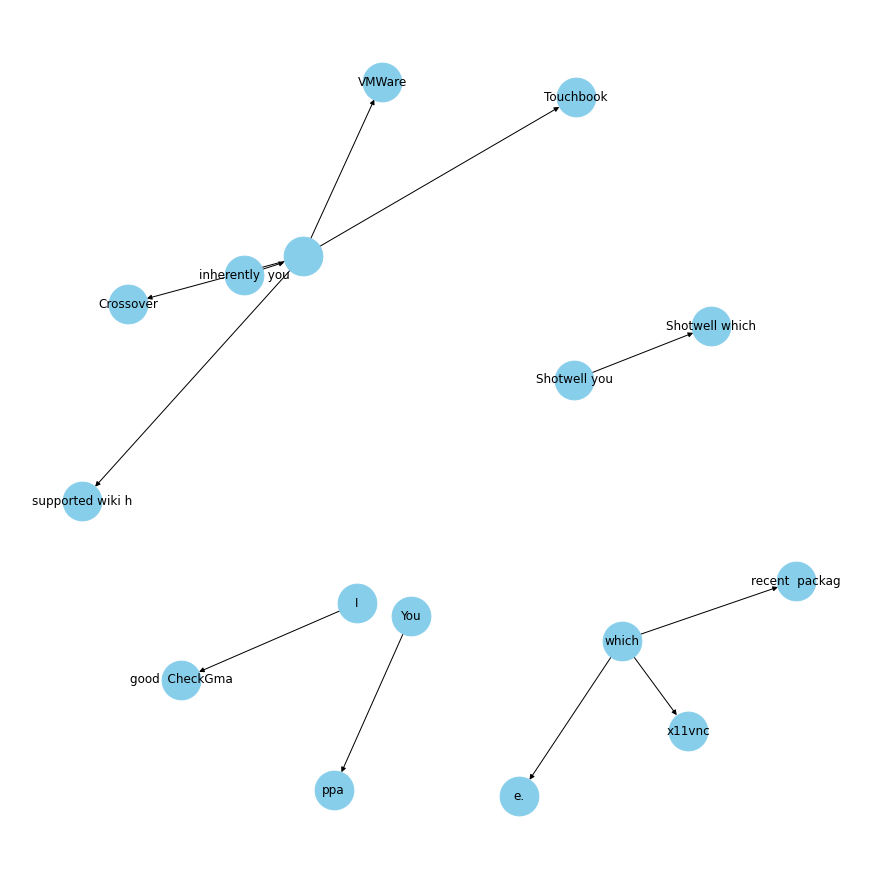

In [88]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="nofollow"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

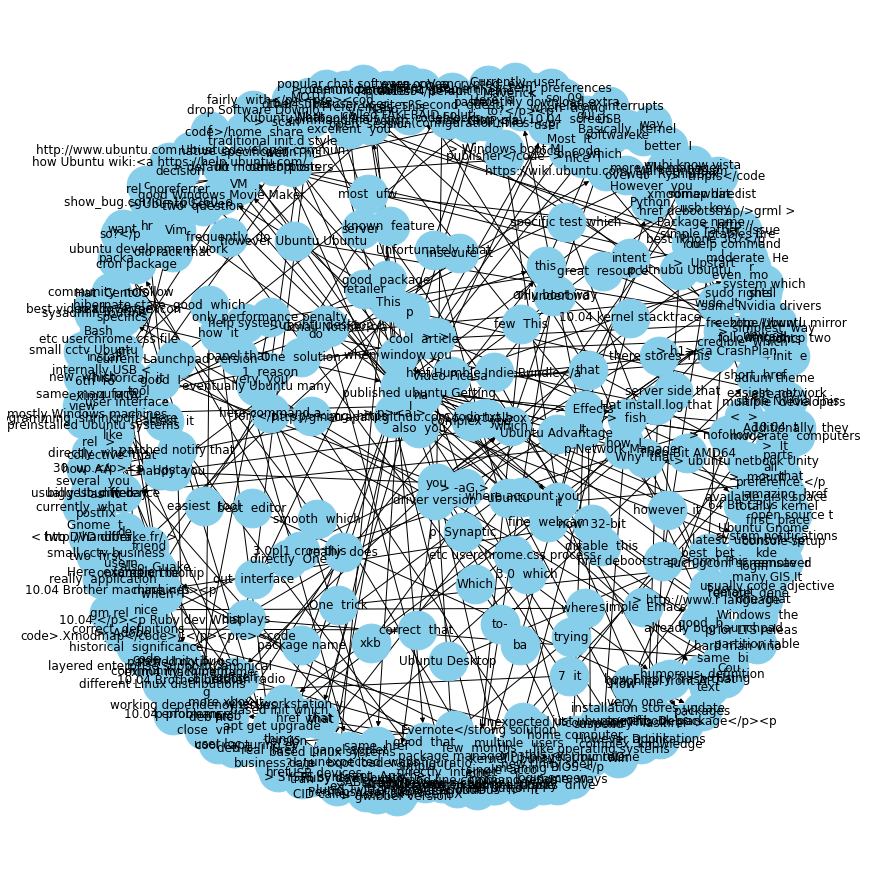

In [110]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

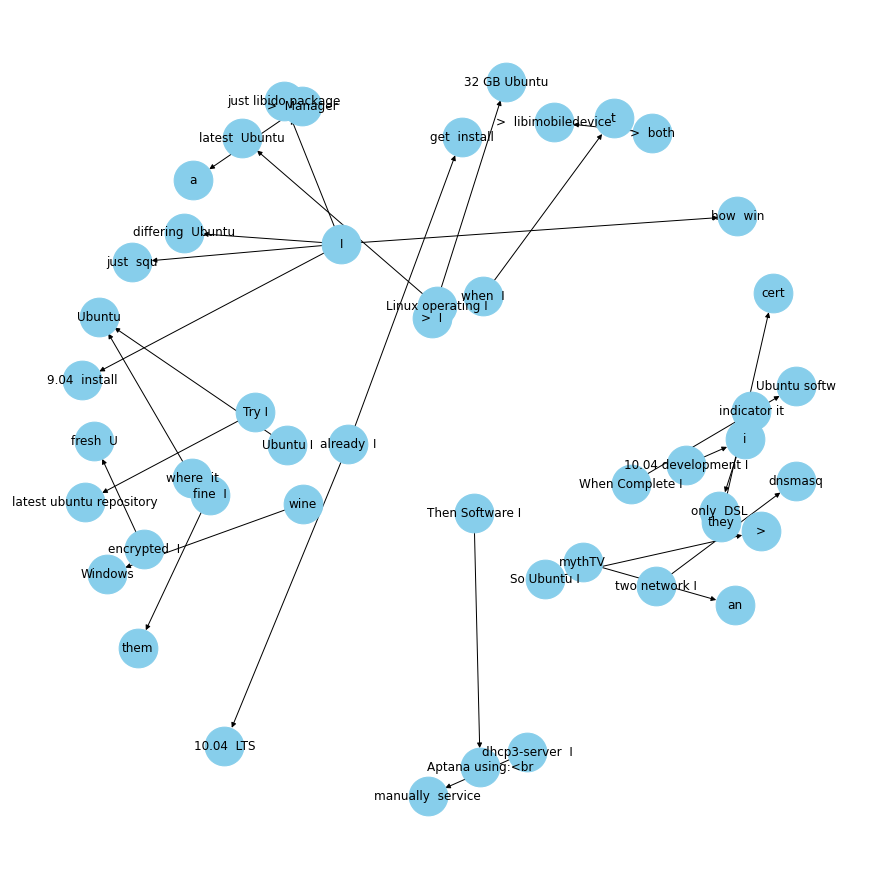

In [111]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="installed"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()